## Imports

In [1]:
import numpy as np

import torch

import matplotlib.pyplot as plt
## torchvision related imports
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import make_grid
## models and transforms
from torchvision.transforms.functional import convert_image_dtype
from torchvision.models.segmentation import fcn_resnet50


## utility Functions

In [2]:

## utilities for multiple images
def img_show(images):

    if not isinstance(images, list):
        ## generalise cast images to list
        images = [images]
    fig, axis = plt.subplots(ncols=len(images), squeeze=False)
    for i, image in enumerate(images):
        image = image.detach() # detached from current DAG, no gradient
        image = F.to_pil_image(image)
        axis[0, i].imshow(np.asarray(image))
        axis[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## read and visualize image with bounding box

In [3]:
## get an image on which segmentation needs to be done
img1 = read_image("/content/semantic_example_highway.jpg")

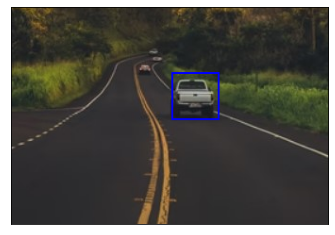

In [10]:
box_car = torch.tensor([ [170, 70, 220, 120]], dtype=torch.float) ## (xmin,ymin,xmax,ymax)
colors = ["blue"]
check_box = draw_bounding_boxes(img1, box_car, colors=colors, width=2)
img_show(check_box)

In [11]:
## batch for images
batch_imgs = torch.stack([img1])
batch_torch = convert_image_dtype(batch_imgs, dtype=torch.float)


## load and configure model

In [12]:
model = fcn_resnet50(pretrained=True, progress=False)
## switching on eval mode
model = model.eval()
# standard normalizing based on train config
normalized_batch_torch = F.normalize(batch_torch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
result = model(normalized_batch_torch)['out']

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


torch.Size([1, 21, 231, 337]) -4.9306745529174805 13.575248718261719


## get segmentation

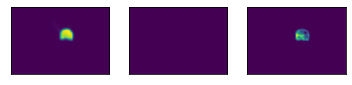

In [13]:
classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_idx = {cls: idx for (idx, cls) in enumerate(classes)}

normalized_out_masks = torch.nn.functional.softmax(result, dim=1)

car_mask = [
    normalized_out_masks[img_idx, class_to_idx[cls]]
    for img_idx in range(batch_torch.shape[0])
    for cls in ('car', 'pottedplant','bus')
]

img_show(car_mask)